# 5.1 Criação de Modelos de Machine Learning - Tunning

## Carregar dados tratados

In [83]:
# ! pip install seaborn
# ! pip install plotly
# ! pip install statsmodels
# ! pip install sklearn

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

In [85]:
def carregar_joblib(file_name: str = "../out/result_analise_desc.joblib"):
    df = joblib.load(file_name)
    return df

In [86]:
def split_dados(df, test_size: float = 0.2):
    X = df.drop(["decisao"], axis=1)
    y = df["decisao"]

    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=test_size, random_state=42)

    return (X_treino, X_teste, y_treino, y_teste)

In [87]:
def plot_confusion_matrix_heat(cf_matrix):
    cf_matrix.index.name = 'Atual'
    cf_matrix.columns.name = 'Predito'
    
    cf_nd_array = cf_matrix.to_numpy()
    cf_flatten = cf_nd_array.flatten()

    group_names = ["TN", "FP", "FN", "TP"]
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_flatten]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_flatten / np.sum(cf_nd_array)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    print(cf_matrix.shape)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')


In [88]:
def avaliar(y_teste, y_prev):
    print("Reporte base de teste")
    report = classification_report(y_teste, y_prev, target_names=["Vender", "Comprar"])
    print(report)
    cf_matrix = pd.DataFrame(confusion_matrix(y_teste, y_prev), index=["Vender", "Comprar"], columns=["Vender", "Comprar"])
    plot_confusion_matrix_heat(cf_matrix)
    plt.show()
    metric = metrics.average_precision_score(y_teste, y_prev)
    print("Precision: ", metric)
    print("Acuracia treinamento: ", metrics.accuracy_score(y_teste, y_prev))
    print("#" * 50)
    return metric

# ML modelo

In [89]:
def definir_modelo_ml() -> dict:
    return dict(AdaBoost={'modelo_base': AdaBoostClassifier(), 
                          'modelo_tunado': None})

In [90]:
def treinar_modelo_base(modelos, splited_data):

    X_treino, _, y_treino, _ = splited_data

    for nome, modelo in modelos.items():
        modelo = modelo.get('modelo_base')
        modelo.fit(X_treino, y_treino)

        modelos[nome]['modelo_base'] = modelo
    
    return modelos

## Tunning do modelo

In [91]:
def fit_tunning_rand_search_ada(X_treino, y_treino):
    print("Tunning randomized search AdaBoost")

    # Create the random grid
    param = {'n_estimators': [50, 80, 90, 100],
             'learning_rate': [0.2, 1.0, 0.1],
             'algorithm': ["SAMME", "SAMME.R"], 
             'random_state':[None]}

    print(param)

    rf_random = RandomizedSearchCV(estimator=AdaBoostClassifier(),
                                   param_distributions=param,
                                   cv=10,
                                   verbose=0,
                                   scoring="precision",
                                   random_state=42,
                                   n_jobs=-1)

    # Fit the random search model
    return rf_random.fit(X_treino, y_treino)

In [92]:
def run_ada_boost_tunning(splited_data):

    X_treino, X_teste, y_treino, y_teste = splited_data
    
    resultado_grid = fit_tunning_rand_search_ada(X_treino.values, y_treino.values)

    print("Ajuste Adaboost feito")

    print("Best params", resultado_grid.best_params_)

    modelo_tunado = resultado_grid.best_estimator_

    return modelo_tunado

In [93]:
def predict_e_avaliar_por_modelo(modelo, splited_data, nome):
    X_treino, X_teste, y_treino, y_teste = splited_data

    prev = modelo.predict(X_teste)
    print(nome)
    print(f"\nAcuracia treinamento {nome}: {modelo.score(X_treino, y_treino)}\n")
    print(f"\nAcuracia previsto {nome}: {metrics.accuracy_score(y_teste, prev)}\n")

    return avaliar(y_teste, prev)

def compare_tunning(modelos: dict, splited_data):

    metrics = {}
    for nome, modelos_dict in modelos.items():
        metrics[nome + '_base'] =predict_e_avaliar_por_modelo(modelos_dict['modelo_base'], splited_data, nome + '_base')
        metrics[nome + '_tunned'] =predict_e_avaliar_por_modelo(modelos_dict['modelo_tunado'], splited_data, nome + '_tunned')
    
    # barplot comparacao 3 modelos tunados
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x=list(metrics.keys()), y=list(metrics.values()))
    ax.set(xlabel="Modelos", ylabel="Recall", title="Recall por Modelo")
    

In [94]:
def run_tunning_fit(modelos, splited_data):
    '''
        Executa os tunnings com randomized search cv e armazena o modelo tunado
    '''
    modelos['AdaBoost']['modelo_tunado'] = run_ada_boost_tunning(splited_data)

    return modelos


Tunning randomized search AdaBoost
{'n_estimators': [50, 80, 90, 100], 'learning_rate': [0.2, 1.0, 0.1], 'algorithm': ['SAMME', 'SAMME.R'], 'random_state': [None]}
Ajuste Adaboost feito
Best params {'random_state': None, 'n_estimators': 90, 'learning_rate': 1.0, 'algorithm': 'SAMME.R'}
AdaBoost_base

Acuracia treinamento AdaBoost_base: 0.633418043202033


Acuracia previsto AdaBoost_base: 0.5863309352517986

Reporte base de teste
              precision    recall  f1-score   support

      Vender       0.58      0.56      0.57       135
     Comprar       0.60      0.61      0.60       143

    accuracy                           0.59       278
   macro avg       0.59      0.59      0.59       278
weighted avg       0.59      0.59      0.59       278

(2, 2)


/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


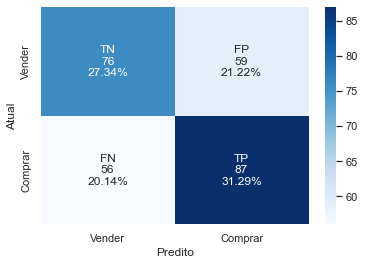

Precision:  0.5639735744692875
Acuracia treinamento:  0.5863309352517986
##################################################
AdaBoost_tunned


/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(



Acuracia treinamento AdaBoost_tunned: 0.6632782719186785


Acuracia previsto AdaBoost_tunned: 0.579136690647482

Reporte base de teste
              precision    recall  f1-score   support

      Vender       0.56      0.59      0.58       135
     Comprar       0.60      0.57      0.58       143

    accuracy                           0.58       278
   macro avg       0.58      0.58      0.58       278
weighted avg       0.58      0.58      0.58       278

(2, 2)


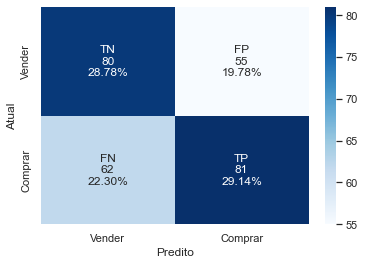

Precision:  0.5603827509773341
Acuracia treinamento:  0.579136690647482
##################################################


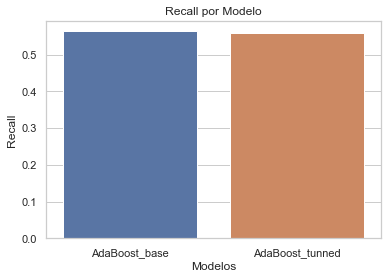

In [95]:
def main():

    df = carregar_joblib()

    modelo = definir_modelo_ml()

    splited_data = split_dados(df, test_size=0.15)

    modelo = treinar_modelo_base(modelo, splited_data)

    modelo = run_tunning_fit(modelo, splited_data)

    compare_tunning(modelo, splited_data)

    return modelo

modelos = main()